In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv
from scipy import optimize

## Burgers
$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$
### experiment design

1.$ dx = 0.05, dt = 0.0125(= 45 sec), \nu = 0.05 $

2.number of points = 81, member = 4, number of observations = 81(all)

3.number of DA cycles = 5, interval between cycles = 3 minutes(= every 4 steps)

4.obs mean = 0.0, obs stdv = 0.1, obs PDF = Gaussian

5.initial state = begin forecast 5 cycles before TRUE

6.ensemble perturbation = lagged forecast (lag interval = 1 cycle( 4 steps ))


In [2]:
def initialize():
    global u, x, dx, dt, alph
    
    dx = 2.0*xmax/(jmax-1)
    dt = c*dx
    alph = s*dx*dx/dt
    x = np.arange(jmax)*dx - xmax
    u = np.zeros((ntime,jmax))
    u[0,0] = 1.0 

In [18]:
def burgers(ub,c,s):
    jmax = ub.size
    ua = np.zeros(jmax)
    ua[0] = ub[0]
    ua[jmax-1] = ub[jmax-1]
    aa = np.array([0.0,c])
    bb = np.array([0.5*c,-c])
    cc = np.array([-0.5*c,0.0])
    ef = np.empty((3,jmax))
    dum0 = np.zeros(jmax)
    dum0[1:jmax-1] = 0.5*s*(ub[:jmax-2] - 2.0*ub[1:jmax-1] + ub[2:jmax])
    for ip in range(2):
        if(ip==0):
            ud = ub
        else:
            ud = ua  
        ef[0] = 0.5*np.roll(ud, 1)*np.roll(ud, 1)   # 0.5*u[j-1]*u[j-1]
        ef[1] = 0.5*ud*ud                           # 0.5*u[j]*u[j]
        ef[2] = 0.5*np.roll(ud, -1)*np.roll(ud, -1) # 0.5*u[j+1]*u[j+1]
        ef[:,0] = 0.0
        ef[:,jmax-1] = 0.0
        dum = np.zeros(jmax)
        #for j in range(1,jmax-1):
            #dum[j] = 0.5*s*(ub[j-1] - 2.0*ub[j] + ub[j+1])
        if(ip==1):
            dum = dum0
        else:
            for j in range(1,jmax-1):
                jp = j+1
                if(j==jmax-2):
                    jp = j
                dum[j] = dum0[j] + 0.5*s*(ub[j] - 2.0*ub[j+1] + ub[jp+1]) + 0.5*(ub[jp] - ub[j])
        ua = ub + aa[ip]*ef[0] + bb[ip]*ef[1] + cc[ip]*ef[2] + dum
        
    return ua

In [19]:
def burgers1(ub, c, s):
    jmax = ub.size
    #ua = ub
    ua = np.zeros(jmax)
    ua[0] = ub[0]
    ua[jmax-1] = ub[jmax-1]
    ef = np.zeros(jmax)
    dum0 = np.zeros(jmax)
    dum0[1:jmax-1] = 0.5 * s * (ub[0:jmax-2] - 2.0 * ub[1:jmax-1] + ub[2:jmax])
    dum = np.zeros(jmax)
    for ip in range(2):
        if ip == 0:
            ud = ub
        else:
            ud = ua  
        ef = 0.5 * ud * ud
        if ip == 0:
            dum[0] = 0.0
            dum[1:jmax-2] = dum0[1:jmax-2] + 0.5 * s * (ub[1:jmax-2] - 2.0 * ub[2:jmax-1] + ub[3:jmax]) - 0.5 * (ub[2:jmax-1] - ub[1:jmax-2])
            dum[jmax-2] = dum[jmax-2] + 0.5 * s * (ub[jmax-2] - ub[jmax-1])
            ua[1:jmax-1] = ub[1:jmax-1] + dum[1:jmax-1] + 0.5 * c * (ef[1:jmax-1] - ef[2:jmax])
        else:
            ua[1:jmax-1] = ub[1:jmax-1] + dum0[1:jmax-1] + c * (ef[0:jmax-2] - ef[1:jmax-1])
    return ua

In [20]:
def l_operator(f, u, dx, nu):
# NB u is defined at integral index
# u[i-1/2] = (u[i-1] + u[i]) / 2
# u[i+1/2] = (u[i] + u[i+1]) / 2
# u[i+1/2] - u[i-1/2] = (u[i+1] - u[i-1]) / 2
    l = np.zeros_like(u)
    l[1:-1] = -0.5 * (f[2:] - f[0:-2]) / dx \
        + nu / dx**2 * (u[2:] - 2 * u[1:-1] + u[0:-2])
    return l


def step(u, dx, dt, nu):
    f = 0.5 * u**2
    u1 = u + dt * l_operator(f, u, dx, nu)
    return 0.5 * (u + u1 + dt * l_operator(f, u1, dx, nu))

81 500 0.25 0.05 0.0125 2.0 0.25 0.05000000000000001
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6.25
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.99999999e-01 1.00000000e+00
 1.00000000e+00 1.00000001e+00 1.00000002e+00 1.00000002e+00
 9.99999938e-01 9.99999

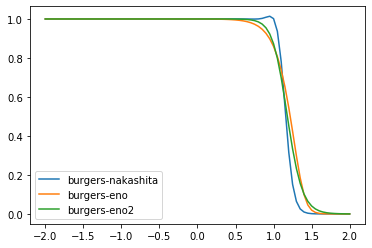

In [21]:
jmax = 81
ntime = 500
xmax = 2.0
c = 0.25
s = 0.25

#dx = 2.0*xmax/(jmax-1)
#dt = c*dx
initialize()

print(jmax,ntime,c,dx,dt,xmax,s,alph)

print(u[0])
for k in range(1,ntime):
    u[k] = burgers(u[k-1],c,s)
    #u[k] = burgers1(u[k-1],c,s)
    #print(u[k])
    #ub[:] = ua[:]
print(dt*ntime)
print(u[-1])
plt.plot(x,u[ntime-1],label='burgers-nakashita')

initialize()

print(jmax,ntime,c,dx,dt,xmax,s,alph)

print(u[0])
for k in range(1,ntime):
    #u[k] = burgers(u[k-1],c,s)
    u[k] = burgers1(u[k-1],c,s)
    #print(u[k])
    #ub[:] = ua[:]
print(dt*ntime)
print(u[-1])
plt.plot(x,u[ntime-1],label='burgers-eno')

initialize()

print(jmax,ntime,c,dx,dt,xmax,s,alph)

print(u[0])
for k in range(1, ntime):
    u[k] = step(u[k-1], dx, dt, alph)
print(dt*ntime)
print(u[-1])
plt.plot(x,u[-1],label='burgers-eno2')

plt.legend()
plt.savefig("burgers.png")
plt.show()

81 20 0.25 0.05 0.0125 2.0 0.25 0.05000000000000001
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25
[1.00000000e+00 9.32710045e-01 7.95495451e-01 5.97314036e-01
 3.87474129e-01 2.18344742e-01 1.09094488e-01 4.94204880e-02
 2.06338844e-02 8.01634311e-03 2.91188330e-03 9.91134474e-04
 3.16437474e-04 9.48093186e-05 2.66643537e-05 7.04002798e-06
 1.74489580e-06 4.05919429e-07 8.85998696e-08 1.81346591e-08
 3.47799487e-09 6.24364079e-10 1.04773701e-10 1.64073304e-11
 2.39268582e-12 3.24100210e-13 4.06493516e-14 4.70260130e-15
 4.99437133e-16 4.84105925e-17 4.25140834e-18 3.35120179e-19
 2.34238131e-20 1.42823770e-21 7.42489208e-23 3.18090272e-24
 1.06287479e-25 2.49696067e-27 3.18727206e-29 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

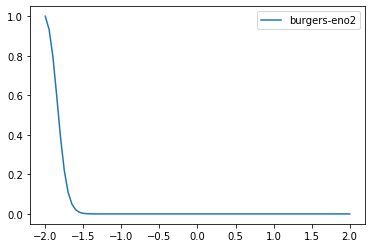

In [20]:
jmax = 81
ntime = 20
xmax = 2.0
c = 0.25
s = 0.25

#dx = 2.0*xmax/(jmax-1)
#dt = c*dx
initialize()

print(jmax,ntime,c,dx,dt,xmax,s,alph)

print(u[0])
for k in range(1, ntime):
    u[k] = step(u[k-1], dx, dt, alph)
print(dt*ntime)
print(u[-1])
plt.plot(x,u[-1],label='burgers-eno2')
plt.legend()
plt.show()

n=81 nu=1.0 dt=2.000e-03 tmax=2.0 tsave=0.5
R=1.0 dx=7.854e-02 umax=1.0 c=0.025464790894703257 s=0.32422778765548094 nt=1001
step 00000
step 00001
step 00002
step 00003
step 00004
step 00005
step 00006
step 00007
step 00008
step 00009
step 00010
step 00011
step 00012
step 00013
step 00014
step 00015
step 00016
step 00017
step 00018
step 00019
step 00020
step 00021
step 00022
step 00023
step 00024
step 00025
step 00026
step 00027
step 00028
step 00029
step 00030
step 00031
step 00032
step 00033
step 00034
step 00035
step 00036
step 00037
step 00038
step 00039
step 00040
step 00041
step 00042
step 00043
step 00044
step 00045
step 00046
step 00047
step 00048
step 00049
step 00050
step 00051
step 00052
step 00053
step 00054
step 00055
step 00056
step 00057
step 00058
step 00059
step 00060
step 00061
step 00062
step 00063
step 00064
step 00065
step 00066
step 00067
step 00068
step 00069
step 00070
step 00071
step 00072
step 00073
step 00074
step 00075
step 00076
step 00077
step 00078
step 0

step 00801
step 00802
step 00803
step 00804
step 00805
step 00806
step 00807
step 00808
step 00809
step 00810
step 00811
step 00812
step 00813
step 00814
step 00815
step 00816
step 00817
step 00818
step 00819
step 00820
step 00821
step 00822
step 00823
step 00824
step 00825
step 00826
step 00827
step 00828
step 00829
step 00830
step 00831
step 00832
step 00833
step 00834
step 00835
step 00836
step 00837
step 00838
step 00839
step 00840
step 00841
step 00842
step 00843
step 00844
step 00845
step 00846
step 00847
step 00848
step 00849
step 00850
step 00851
step 00852
step 00853
step 00854
step 00855
step 00856
step 00857
step 00858
step 00859
step 00860
step 00861
step 00862
step 00863
step 00864
step 00865
step 00866
step 00867
step 00868
step 00869
step 00870
step 00871
step 00872
step 00873
step 00874
step 00875
step 00876
step 00877
step 00878
step 00879
step 00880
step 00881
step 00882
step 00883
step 00884
step 00885
step 00886
step 00887
step 00888
step 00889
step 00890
step 00891

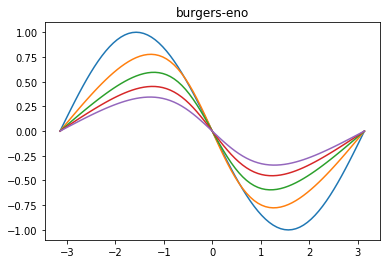

In [17]:
n = 81
nu = 1.0
dt = 0.002
tmax = 2.0
tsave = 0.5
reynolds_number = 1.0

x = np.linspace(-np.pi, np.pi, n)
dx = x[1] - x[0]
u = -reynolds_number * np.sin(x)
umax = np.amax(np.abs(u))
c = umax * dt / dx
s = nu * dt / dx / dx
nt = int(tmax / dt) + 1

print("n={} nu={} dt={:7.3e} tmax={} tsave={}".format(n, nu, dt, tmax, tsave))
print("R={} dx={:7.3e} umax={} c={} s={} nt={}".format(reynolds_number, dx, umax, c, s, nt))

np.savetxt("x.txt".format(0), x)
np.savetxt("u{:05d}-e.txt".format(0), u)
fig, ax = plt.subplots()
for k in range(nt):
    print("step {:05d}".format(k))
    if k * dt % tsave == 0:
        np.savetxt("u{:05d}-e.txt".format(k), u)
        ax.plot(x, u)
    u = burgers(u, c, s)
    #u = burgers1(u, c, s)
plt.title("burgers-eno")
fig.savefig("u-eno.png")
plt.show()

## Validation

### initial condition
$$
u_j^{n=0} = -2\nu \frac{(\partial \phi/\partial x)_j}{\phi_j} + 4
$$
where:
$$
\phi = \exp \left( \frac{-x^2}{4\nu} \right) + \exp \left[\frac{-(x-2\pi)^2}{4\nu} \right]
$$
$$
\frac{\partial \phi}{\partial x} = -\frac{x}{2\nu} \exp\left( \frac{-x^2}{4\nu} \right) - \frac{x-2\pi}{2\nu}\exp\left[\frac{-(x-2\pi)^2}{4\nu}\right]
$$

### boundary condition
Periodic:
$$
u_{j=0}^n=u_{j=jmax}^n
$$

### analytical solution
$$
u_j^{n} = -2\nu \frac{(\partial \phi/\partial x)_j}{\phi_j} + 4
$$
where:
$$
\phi = \exp \left( \frac{-(x-4t)^2}{4\nu(t+1)} \right) + \exp \left[\frac{-(x-4t-2\pi)^2}{4\nu(t+1)} \right]
$$
$$
\frac{\partial \phi}{\partial x} = -\frac{x-4t}{2\nu(t+1)} \exp\left( \frac{-(x-4t)^2}{4\nu(t+1)} \right) - \frac{x-4t-2\pi}{2\nu(t+1)}\exp\left[\frac{-(x-4t-2\pi)^2}{4\nu(t+1)}\right]
$$

In [8]:
def initial(x,nu):
    from numpy import exp as exp
    
    u = np.empty(len(x))
    phi = np.empty(len(x))
    dphi = np.empty(len(x))
    
    phi = exp(-x*x*0.25/nu) + exp(-(x-2.0*pi)*(x-2.0*pi)*0.25/nu)
    dphi = -0.5*x*exp(-x*x*0.25/nu)/nu - 0.5*(x-2.0*pi)*exp(-(x-2.0*pi)*(x-2.0*pi)*0.25/nu)/nu
    
    u = -2.0*nu*dphi/phi + 4
    
    return u

In [9]:
def analytical(x,t,nu):
    from numpy import exp as exp

    u = np.empty(len(x))
    phi = np.empty(len(x))
    dphi = np.empty(len(x))
    
    x_ = x - 4.0*t
    nu_ = nu*(t+1.0)
    phi = exp(-x_*x_*0.25/nu_) + exp(-(x_-2.0*pi)*(x_-2.0*pi)*0.25/nu_)
    dphi = -0.5*x_*exp(-x_*x_*0.25/nu_)/nu_ - 0.5*(x_-2.0*pi)*exp(-(x_-2.0*pi)*(x_-2.0*pi)*0.25/nu_)/nu_
    
    u = -2.0*nu*dphi/phi + 4
    
    return u

In [10]:
def burgers(ub,c,s):
    #jmax = len(ub)
    ua = np.empty(jmax)
    #ua[0] = ub[0]
    #ua[jmax-1] = ub[jmax-1]
    aa = np.array([0.0,c])
    bb = np.array([0.5*c,-c])
    cc = np.array([-0.5*c,0.0])
    ef = np.empty((3,jmax))
    dum0 = 0.5*s*(np.roll(ub,1) - 2.0*ub + np.roll(ub,-1))
    for ip in range(2):
        if(ip==0):
            u = ub
        else:
            u = ua  
        ef[0] = 0.5*np.roll(u, 1)*np.roll(u, 1)   # 0.5*u[j-1]*u[j-1]
        ef[1] = 0.5*u*u                           # 0.5*u[j]*u[j]
        ef[2] = 0.5*np.roll(u, -1)*np.roll(u, -1) # 0.5*u[j+1]*u[j+1]
        #ef[:,0] = 0.0
        #ef[:,jmax-1] = 0.0
        dum = np.zeros(jmax)
        #for j in range(1,jmax-1):
        #dum = 0.5*s*(np.roll(ub,1) - 2.0*ub + np.roll(ub,-1))
        if(ip==0):
            dum = dum0
            #continue
            #jp = j+1
            #if(j==jmax-2):
            #    jp = j
        else:
            dum = dum0 + 0.5*s*(ub - 2.0*np.roll(ub,-1) + np.roll(ub,-2)) + 0.5*(np.roll(ub,-1) - ub)
            #dum = dum0 + 0.5*s*(ub - 2.0*np.roll(ub,-1) + np.roll(ub,-2)) - 0.5*(np.roll(ub,-1) - ub)
        ua = ub + aa[ip]*ef[0] + bb[ip]*ef[1] + cc[ip]*ef[2] + dum
        
    return ua

In [11]:
def burgers1(ub, c, s):
    jmax = ub.size
    #ua = ub
    ua = np.zeros(jmax)
    #ua[0] = ub[0]
    #ua[jmax-1] = ub[jmax-1]
    ef = np.zeros(jmax)
    dum0 = np.zeros(jmax)
    dum0 = 0.5 * s * (np.roll(ub,1) - 2.0 * ub + np.roll(ub,-1))
    dum = np.zeros(jmax)
    for ip in range(2):
        if ip == 0:
            ud = ub
        else:
            ud = ua  
        ef = 0.5 * ud * ud
        if ip == 0:
            dum = dum0 + 0.5 * s * (ub - 2.0 * np.roll(ub,-1) + np.roll(ub,-2)) - 0.5 * (np.roll(ub,-1) - ub)
            ua = ub + dum + 0.5 * c * (ef - np.roll(ef,1))
        else:
            ua = ub + dum0 + c * (np.roll(ef,-1) - ef)
    return ua

In [12]:
def l_operator(f, u, dx, nu):
# NB u is defined at integral index
# u[i-1/2] = (u[i-1] + u[i]) / 2
# u[i+1/2] = (u[i] + u[i+1]) / 2
# u[i+1/2] - u[i-1/2] = (u[i+1] - u[i-1]) / 2
    l = np.zeros_like(u)
    l = -0.5 * (np.roll(f,-1) - np.roll(f,1)) / dx \
        + nu / dx**2 * (np.roll(u,-1) - 2 * u + np.roll(u,1))
    return l


def step(u, dx, dt, nu):
    f = 0.5 * u**2
    u1 = u + dt * l_operator(f, u, dx, nu)
    return 0.5 * (u + u1 + dt * l_operator(f, u1, dx, nu))

In [48]:
def cal_u(ub,c,s):
    ua = np.zeros(jmax)
    ua = ub - ub*c*(ub - np.roll(ub,1)) + s*(np.roll(ub,-1)-2.0*ub+np.roll(ub,1))
    return ua

In [15]:
def plot_u(ua,ue,x,ntime,title):
    import matplotlib.cm as cm
    plt.figure()
    ax = plt.subplot(111)
    colour = iter(cm.rainbow(np.linspace(0,20,ntime)))
    for n in range(0, ntime, 20):
        c = next(colour)
        #ax.plot(x,ue[n],'ko',markerfacecolor='none',alpha=0.5,label='i='+str(n)+' numerical')
        #ax.plot(x,ua[n],linestyle='-',c=c,label='i='+str(n)+' analytical')
        ax.plot(x,ue[n],linestyle='-',c=c,label='i='+str(n)+' analytical')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.7, box.height])
    ax.legend( bbox_to_anchor=(1.02,1), loc=2)
    plt.xlabel('x (radians)')
    plt.ylabel('u (m/s)')
    plt.ylim([0,8.0])
    plt.xlim([0,2.0*pi])
    plt.title(title)
    plt.show()

151 151 6.283185307179586 0.5 0.041887902047863905 0.0033333333333333335 0.07957747154594769 0.09498860966469169 0.05
[3.99639209 4.02891889 4.07016322 4.11191149 4.15365977 4.19540805
 4.23715632 4.2789046  4.32065287 4.36240115 4.40414942 4.4458977
 4.48764598 4.52939425 4.57114253 4.6128908  4.65463908 4.69638735
 4.73813563 4.77988391 4.82163218 4.86338046 4.90512873 4.94687701
 4.98862528 5.03037356 5.07212184 5.11387011 5.15561839 5.19736666
 5.23911494 5.28086321 5.32261149 5.36435977 5.40610804 5.44785632
 5.48960459 5.53135287 5.57310114 5.61484942 5.65659769 5.69834597
 5.74009425 5.78184252 5.8235908  5.86533907 5.90708735 5.94883562
 5.9905839  6.03233218 6.07408045 6.11582873 6.157577   6.19932528
 6.24107355 6.28282183 6.32457011 6.36631838 6.40806666 6.44981493
 6.49156321 6.53331148 6.57505976 6.61680804 6.65855631 6.70030459
 6.74205286 6.78380115 6.82554961 6.86730049 6.90908531 6.95134473
 6.99983069 7.09749421 7.12145694 4.81720587 1.83614617 1.04413457
 0.98914884 

[3.4432153  3.47889366 3.51459432 3.55031411 3.58599468 3.62157231
 3.65709498 3.69277003 3.72882421 3.76524048 3.80159251 3.83715346
 3.87124139 3.90357785 3.93443317 3.96449432 3.99457027 4.02531433
 4.05708164 4.08993403 4.12373377 4.15825541 4.19327102 4.22859513
 4.26409698 4.29969401 4.33533866 4.37100569 4.40668262 4.44236369
 4.47804638 4.5137297  4.54941323 4.58509684 4.62078047 4.6564641
 4.69214774 4.72783138 4.76351502 4.79919867 4.83488231 4.87056595
 4.90624959 4.94193323 4.97761687 5.01330051 5.04898415 5.08466779
 5.12035143 5.15603507 5.19171871 5.22740235 5.26308599 5.29876964
 5.33445327 5.3701369  5.40582069 5.44150376 5.47718821 5.51287362
 5.54854738 5.58424228 5.61995782 5.65553592 5.69121468 5.72735068
 5.7626358  5.79693783 5.83485214 5.87405184 5.90153387 5.92877366
 5.98865906 6.04522773 6.02024855 6.00011991 6.16471143 6.34162621
 6.14808168 5.84284115 6.18109907 6.87901942 6.61019623 5.53648933
 5.55057493 7.0792512  7.4920186  5.75361166 4.83804483 6.69832

 2.94618626]
[2.96972956 3.0005062  3.03128285 3.06205949 3.09283612 3.12361274
 3.15438939 3.18516615 3.21594295 3.24671956 3.27749562 3.30827125
 3.33904744 3.36982592 3.40060762 3.43139037 3.46216773 3.49293125
 3.52367709 3.55441433 3.58516951 3.61598152 3.64688451 3.67788306
 3.70892919 3.73991273 3.77067255 3.80102867 3.83082644 3.85997873
 3.88849236 3.91647036 3.94409071 3.97156942 3.99911998 4.02691994
 4.05509115 4.08369477 4.11273822 4.14218893 4.17199027 4.20207573
 4.2323796  4.26284369 4.29342034 4.324073   4.35477511 4.38550824
 4.41626022 4.44702327 4.47779262 4.50856546 4.53934017 4.57011585
 4.60089203 4.63166846 4.66244501 4.69322158 4.72399821 4.75477495
 4.78555151 4.81632778 4.84710478 4.87788275 4.90865808 4.93943019
 4.97021074 5.00100247 5.03177006 5.06249882 5.09328741 5.12420475
 5.15500362 5.18541085 5.21595592 5.24755603 5.27934516 5.30871371
 5.33629719 5.36830343 5.40687823 5.44011114 5.45641271 5.47234533
 5.52083286 5.59174974 5.61849843 5.57654838 5.56

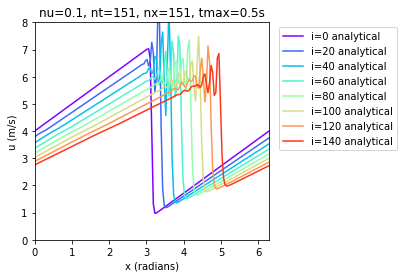

In [16]:
from numpy import pi as pi
jmax = 151
tmax = 0.5
ntime = 151
xmax = 2.0*pi
nu = 0.05

dx = xmax/(jmax-1)
dt = tmax/(ntime-1)
c = dt/dx
s = nu*dt/dx/dx

print(jmax,ntime,xmax,tmax,dx,dt,c,s,nu)

x = np.arange(jmax)*dx
ua = np.empty((ntime,jmax))
ue = np.empty((ntime,jmax))
ua[0] = initial(x,nu)
ue[0] = initial(x,nu)

for k in range(1,ntime):
    t = k*dt
    ua[k] = analytical(x,t,nu)
    #ue[k] = burgers(ue[k-1],c,s)
    #ue[k] = burgers1(ue[k-1],c,s)
    ue[k] = step(ue[k-1],dx,dt,nu)
    #ue[k] = cal_u(ue[k-1],c,s)
    print(ue[k])

plot_u(ua,ue,x,ntime,'nu=0.1, nt=151, nx=151, tmax=0.5s')